Preparation of the dataset for the homemade backtest

In [1]:
import pandas as pd
import numpy as np
from numpy import int64
from matplotlib import pyplot as plt
import importlib

import sqlite_io as sio
import backtest_portfolio as bp

importlib.reload(bp)

<module 'backtest_portfolio' from 'g:\\Python\\MarketDataEnrichment\\backtest\\backtest_portfolio.py'>

Load datasets

In [2]:
PATH_DATA = "G:\\Python\\Data\\DTS_FULL\\"
df_conf=pd.read_csv(PATH_DATA+"PARIS_TREND_1D_20D_V2_CONF.zip",sep=",",parse_dates=['OPEN_DATETIME'])
df_base=pd.read_csv(PATH_DATA+"PARIS_TREND_1D_20D_V2_BASE.zip",sep=",",index_col=['OPEN_DATETIME','CODE'],parse_dates=['OPEN_DATETIME'])
df_predict=pd.read_pickle(PATH_DATA+"PARIS_TREND_1D_20D_V2_CONF_seq_6_predict.pckl")
df_predict_50=pd.read_pickle(PATH_DATA+"PARIS_TREND_1D_50D_V2_CONF_seq_6_predict.pckl")


df_conf.rename(columns={'TICKER':'CODE'},inplace=True)
df_conf.set_index(['OPEN_DATETIME','CODE'],inplace=True)
df_predict.reset_index(inplace=True)
df_predict.drop(columns=['SEQUENCE'],inplace=True,errors='ignore')
df_predict.rename(columns={'TICKER':'CODE'},inplace=True)
df_predict.set_index(['OPEN_DATETIME','CODE'],inplace=True)
df_predict_50.reset_index(inplace=True)
df_predict_50.drop(columns=['SEQUENCE'],inplace=True,errors='ignore')
df_predict_50.rename(columns={'TICKER':'CODE'},inplace=True)
df_predict_50.set_index(['OPEN_DATETIME','CODE'],inplace=True)
df_base=df_base[['OPEN','HIGH','LOW','CLOSE']]

print(df_conf.head())
print(df_base.head())
print(df_predict.head())
print(df_predict_50.head())

                       pos_sma20  pos_sma50  pos_sma200     rsi14  \
OPEN_DATETIME CODE                                                  
2020-08-03    AB.PA      0.01060   -0.00986     0.20933  51.02805   
              ABCA.PA   -0.00660    0.01520     0.07437  50.86463   
              ABEO.PA   -0.01452   -0.11537    -0.51683  43.71719   
              ABVX.PA   -0.08255   -0.05008     0.13861  39.07921   
              AC.PA     -0.07836   -0.13322    -0.31763  35.85611   

                       sma20_rsi14   ret_5d  pos_top20  pos_top50  pos_bot20  \
OPEN_DATETIME CODE                                                             
2020-08-03    AB.PA       46.19968  0.02917   -0.02217   -0.06070    0.04626   
              ABCA.PA     59.62083 -0.00851   -0.03048   -0.03048    0.01010   
              ABEO.PA     29.87791  0.04673   -0.09920   -0.26638    0.11258   
              ABVX.PA     52.63884 -0.04009   -0.14316   -0.14316    0.03195   
              AC.PA       42.32134 -

Load stocks data

In [3]:
PATH_DB_FWK="G:\\Python\\Data\\sqlite\\dataset_market.db"
if "con_fwk" in locals():
        sio.close_connection(con_fwk)
con_fwk = sio.get_connection(str_db_path=PATH_DB_FWK)

df_info_stocks=sio.get_info_all_stock(con_fwk)
df_info_stocks.head()

,SK_SYMBOL,CODE,NAME,TYPE,REGION,CODE_YAHOO,TRADABLE,SHARESOUTSTANDING
0,12,2MX.PA,2MX ORGANIC,Stock,France,2MX.PA,1,None
1,13,AAA.PA,ALAN ALLMAN ASSOCIATES,Stock,France,AAA.PA,0,45675754
2,14,ABCA.PA,ABC ARBITRAGE,Stock,France,ABCA.PA,1,59608879
3,15,ABEO.PA,ABEO,Stock,France,ABEO.PA,1,7543305
4,16,ABIO.PA,ALBIOMA,Stock,France,ABIO.PA,1,32370737


Merge the 3 dataframes

In [14]:
# rename df_conf.CODE column into CODE and drop df_predict.SEQUENCE column

df_merged = df_conf.merge(df_base, on=['OPEN_DATETIME','CODE'], how='left',validate='one_to_one')
df_merged = df_merged.merge(df_predict, on=['OPEN_DATETIME','CODE'], how='left',validate='one_to_one')
df_merged = df_merged.merge(df_predict_50, on=['OPEN_DATETIME','CODE'], how='left',validate='one_to_one')
df_base_noind=df_merged.reset_index()
df_merged = df_base_noind.merge(df_info_stocks, on='CODE', how='left',validate='many_to_one')
df_merged['DAY']=df_merged['OPEN_DATETIME']
df_merged.set_index(["DAY","CODE"],inplace=True)
df_merged.rename(columns={'lab_perf_20d_x':'lab_perf_20d'},inplace=True)
df_merged.rename(columns={'lab_perf_50d_x':'lab_perf_50d'},inplace=True)
df_merged.rename(columns={'predicted_score_x':'predicted_score_20d'},inplace=True)
df_merged.rename(columns={'predicted_score_y':'predicted_score_50d'},inplace=True)
print(df_merged.columns)


Index(['OPEN_DATETIME', 'pos_sma20', 'pos_sma50', 'pos_sma200', 'rsi14',
       'sma20_rsi14', 'ret_5d', 'pos_top20', 'pos_top50', 'pos_bot20',
       'pos_bot50', 'aroon14_dif', 'macd_dif', 'pos_top_200', 'pos_bot_200',
       'stdev20_sma5', 'pos_stdev20_sma20', 'pos_rsi14_sma20', 'stoch14',
       'cmf_20', 'adx14', 'adx14_neg', 'adx14_pos', 'adx14_dif',
       'pos_avg_vol14', 'pos_sma20_200', 'perf_sma_50_5d', 'perf_sma_200_5d',
       'lab_perf_20d', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'lab_perf_20d_y',
       'predicted_score_20d', 'lab_perf_50d', 'predicted_score_50d',
       'SK_SYMBOL', 'NAME', 'TYPE', 'REGION', 'CODE_YAHOO', 'TRADABLE',
       'SHARESOUTSTANDING'],
      dtype='object')


Clean and calculate usefull columns

In [35]:
df_merged = df_merged[df_merged['TRADABLE'] != 0]
df_clean=df_merged.copy()
df_clean=df_clean[['OPEN_DATETIME','OPEN','HIGH','LOW','CLOSE','pos_sma200','adx14_pos','lab_perf_20d',
                   'predicted_score_20d','lab_perf_50d','predicted_score_50d','NAME','SHARESOUTSTANDING']]
df_clean = df_clean[df_clean['predicted_score_20d'].notna()]
df_clean = df_clean[df_clean['predicted_score_20d'] != '']
df_clean = df_clean[df_clean['predicted_score_20d'] != 'nan']
df_clean = df_clean[df_clean['predicted_score_20d'] != 'NaN']
df_clean = df_clean[df_clean['predicted_score_50d'].notna()]
df_clean = df_clean[df_clean['predicted_score_50d'] != '']
df_clean = df_clean[df_clean['predicted_score_50d'] != 'nan']
df_clean = df_clean[df_clean['predicted_score_50d'] != 'NaN']

# sort by code ascending  then date ascending
df_clean.sort_index(level=[1,0],inplace=True,ascending=[True,True])

df_clean['SHARESOUTSTANDING']=df_clean['SHARESOUTSTANDING'].fillna(0)
df_clean['SHARESOUTSTANDING']=df_clean['SHARESOUTSTANDING'].replace('',0)
df_clean['SHARESOUTSTANDING']=df_clean['SHARESOUTSTANDING'].astype(int64)
df_clean['lab_perf_20d'] = df_clean['lab_perf_20d'].astype(int64).astype(str)
df_clean['lab_perf_50d'] = df_clean['lab_perf_50d'].astype(int64).astype(str)
df_clean['lab_perf_20d_50d'] = (df_clean['lab_perf_20d'] + df_clean['lab_perf_50d']).astype(str).str.zfill(2)
df_clean['predicted_score_20d'] = df_clean['predicted_score_20d'].astype(int64).astype(str)
df_clean['predicted_score_50d'] = df_clean['predicted_score_50d'].astype(int64).astype(str)
df_clean['predicted_score_20d_50d']=(df_clean['predicted_score_20d']+df_clean['predicted_score_50d']).astype(str).str.zfill(2)
df_clean['NAME']=df_clean['NAME'].astype(str)
df_clean['cap_M']=round((df_clean['CLOSE']*df_clean['SHARESOUTSTANDING'])/1000000.0,2)
df_clean['weekday']=df_clean.index.get_level_values(0).weekday
df_clean['week_YYYYWW']=df_clean.index.get_level_values(0).strftime('%Y%W')
df_clean['is_last_day_week'] = df_clean.groupby('week_YYYYWW')['OPEN_DATETIME'].transform(lambda x: x == x.max())
df_clean['code_order'] = df_clean.groupby('OPEN_DATETIME')['cap_M'].rank(ascending=False, method='first')
df_clean['next_open'] = df_clean.groupby('CODE')['OPEN'].shift(-1)


# drop lines where predicted_score is null or empty or nan
print(df_clean.head())
# df_clean.round(5).to_csv(PATH_DATA+"PARIS_TREND_1D_LSTM_20D_50D_V1_BT.zip", sep=",")


                 OPEN_DATETIME  OPEN  HIGH   LOW  CLOSE  pos_sma200  \
DAY        CODE                                                       
2020-08-17 AB.PA    2020-08-17  8.64  8.64  8.53   8.56     0.13524   
2020-08-18 AB.PA    2020-08-18  8.60  8.75  8.45   8.75     0.15637   
2020-08-19 AB.PA    2020-08-19  8.75  9.10  8.73   9.02     0.18774   
2020-08-20 AB.PA    2020-08-20  8.91  9.25  8.91   9.10     0.19403   
2020-08-21 AB.PA    2020-08-21  9.11  9.56  9.09   9.50     0.24222   

                  adx14_pos lab_perf_20d predicted_score_20d lab_perf_50d  \
DAY        CODE                                                             
2020-08-17 AB.PA   17.10871            4                   3            4   
2020-08-18 AB.PA   18.73349            4                   4            3   
2020-08-19 AB.PA   26.27224            4                   4            3   
2020-08-20 AB.PA   27.87007            4                   3            1   
2020-08-21 AB.PA   32.34975            4

In [36]:
# PATH_DATA = "G:\\Python\\Data\\DTS_FULL\\"
# df_clean=pd.read_csv(PATH_DATA+"PARIS_TREND_1D_LSTM_20D_50D_V1_BT.zip",sep=",",parse_dates=['OPEN_DATETIME','DAY'],index_col=['CODE','DAY'])
list_exit_code=['00','01','02','03','04','10','11','12','13','14','20','21','30','31','40','41']
list_entry_code=['44','43']#['44','43','34']
val_pos=1000

df_clean['exit_code'] = np.where(df_clean['predicted_score_20d_50d'].isin(list_exit_code), 1, 0) 

df_clean['exit'] = ((df_clean['exit_code']==1) & (df_clean['exit_code'].shift(1)==1) & (df_clean['is_last_day_week'] ==1)).astype(int)

df_clean['entry_code'] = np.where(df_clean['predicted_score_20d_50d'].isin(list_entry_code), 1, 0)
df_clean['entry_2d'] = ((df_clean['entry_code']==1) & (df_clean['entry_code'].shift(1)==1)).astype(int) 
df_clean['entry'] = (df_clean['entry_2d'] == 1) & (df_clean['is_last_day_week'] ==1) 
df_clean['entry_sma_adx'] = (df_clean['entry'] == 1) & (df_clean['pos_sma200'] > 0) & (df_clean['adx14_pos'] > 20)
df_clean['entry_sma'] = (df_clean['entry'] == 1) & (df_clean['pos_sma200'] > 0) & (df_clean['adx14_pos'] > 0)

df_clean['qtt']=np.floor(val_pos/df_clean['next_open'])
df_clean['SL_20p']=df_clean['CLOSE']*(0.8)

df_clean.head()


,,OPEN_DATETIME,OPEN,HIGH,LOW,CLOSE,pos_sma200,adx14_pos,lab_perf_20d,predicted_score_20d,lab_perf_50d,...,next_open,exit_code,exit,entry_code,entry_2d,entry,entry_sma_adx,entry_sma,qtt,SL_20p
DAY,CODE,,,,,,,,,,,,,,,,,,,,,
2020-08-17,AB.PA,2020-08-17,8.64,8.64,8.53,8.56,0.13524,17.10871,4,3,4,...,8.60,0,0,0,0,False,False,False,116.0,6.848
2020-08-18,AB.PA,2020-08-18,8.60,8.75,8.45,8.75,0.15637,18.73349,4,4,3,...,8.75,0,0,0,0,False,False,False,114.0,7.000
2020-08-19,AB.PA,2020-08-19,8.75,9.10,8.73,9.02,0.18774,26.27224,4,4,3,...,8.91,0,0,0,0,False,False,False,112.0,7.216
2020-08-20,AB.PA,2020-08-20,8.91,9.25,8.91,9.10,0.19403,27.87007,4,3,1,...,9.11,0,0,0,0,False,False,False,109.0,7.280
2020-08-21,AB.PA,2020-08-21,9.11,9.56,9.09,9.50,0.24222,32.34975,4,4,2,...,9.54,0,0,1,0,False,False,False,104.0,7.600


In [37]:
df_clean['cap_filter'] = df_clean['cap_M'].where(df_clean['entry'] == 1, None)
df_clean['entry_order'] = df_clean.groupby('OPEN_DATETIME')['cap_filter'].rank(ascending=False, method='first')
df_clean['entry_filter'] = df_clean.groupby('OPEN_DATETIME')['entry_order'].rank(ascending=False, method='first') <= 50

df_clean['cap_filter_sma_adx'] = df_clean['cap_M'].where(df_clean['entry_sma_adx'] == 1, None)
df_clean['entry_order_sma_adx'] = df_clean.groupby('OPEN_DATETIME')['cap_filter_sma_adx'].rank(ascending=False, method='first')
df_clean['entry_filter_sma_adx'] = df_clean.groupby('OPEN_DATETIME')['entry_order_sma_adx'].rank(ascending=False, method='first') <= 50

df_clean['cap_filter_sma'] = df_clean['cap_M'].where(df_clean['entry_sma'] == 1, None)
df_clean['entry_order_sma'] = df_clean.groupby('OPEN_DATETIME')['cap_filter_sma'].rank(ascending=False, method='first')
df_clean['entry_filter_sma'] = df_clean.groupby('OPEN_DATETIME')['entry_order_sma'].rank(ascending=False, method='first') <= 50

df_clean.head()
df_clean.round(5).to_csv(PATH_DATA+"PARIS_TREND_1D_LSTM_20D_V1_BT_PREPA.zip", sep=",")

-- break point

In [38]:
PATH_DATA = "G:\\Python\\Data\\DTS_FULL\\"
df_saved=pd.read_csv(PATH_DATA+"PARIS_TREND_1D_LSTM_20D_V1_BT_PREPA.zip",sep=",",parse_dates=['OPEN_DATETIME','DAY'],index_col=['CODE','DAY'])
df_clean=df_saved[['OPEN_DATETIME','OPEN','LOW','CLOSE','lab_perf_20d_50d','predicted_score_20d_50d','NAME','cap_M','week_YYYYWW','is_last_day_week','next_open','exit','entry','entry_sma_adx','entry_sma','qtt','SL_20p','entry_order','entry_order_sma_adx','entry_order_sma','entry_filter','entry_filter_sma_adx','entry_filter_sma']]

distinct_codes = df_clean[df_clean['entry'] == 1].index.get_level_values('CODE').unique()

codes_not_in_distinct = df_clean[~df_clean.index.get_level_values('CODE').isin(distinct_codes)].index.get_level_values('CODE').unique().tolist()

print(f"{len(distinct_codes)=}-{len(codes_not_in_distinct)=}")


df_clean = df_clean[~df_clean.index.get_level_values('CODE').isin(codes_not_in_distinct)]
df_clean.head()
df_clean.round(5).to_csv(PATH_DATA+"PARIS_TREND_1D_LSTM_20D_50D_V1_BT_PREPA_CLEAN.zip", sep=",")



len(distinct_codes)=231-len(codes_not_in_distinct)=67


In [39]:
PATH_DATA = "G:\\Python\\Data\\DTS_FULL\\"
df_prepa_bt=pd.read_csv(PATH_DATA+"PARIS_TREND_1D_LSTM_20D_50D_V1_BT_PREPA_CLEAN.zip",sep=",",parse_dates=['OPEN_DATETIME','DAY'],index_col=['DAY','CODE'])
#entry, exit, price, low, sl, priority, nb_stocks

# drop lines after 2023-11-18
df_prepa_bt = df_prepa_bt[df_prepa_bt.index.get_level_values('DAY') <= '2023-10-10']

df_bt=df_prepa_bt[['LOW','next_open','exit','qtt','SL_20p','entry_order_sma','entry_filter_sma']]

df_bt = df_bt.rename(columns={'entry_filter_sma': 'entry', 'next_open': 'price', 'LOW': 'low', 'SL_20p': 'sl', 'qtt': 'quantity','entry_order_sma':'priority'})

df_bt.describe()

,low,price,exit,quantity,sl,priority
count,178890.000000,178889.000000,178890.000000,178889.000000,178890.000000,711.000000
mean,50.587173,51.287783,0.099558,393.783503,41.003888,4.853727
std,107.937342,109.369044,0.299411,4707.053510,87.464261,4.174501
min,0.002700,0.002800,0.000000,0.000000,0.002240,1.000000
25%,9.270000,9.450000,0.000000,18.000000,7.551280,2.000000
50%,21.976900,22.328900,0.000000,44.000000,17.840000,3.000000
75%,54.158900,54.874900,0.000000,105.000000,43.841260,7.000000
max,1909.090900,1946.969700,1.000000,357142.000000,1575.757600,23.000000


In [40]:
initial_cash = 10000
commission = 0.005
freq_print=20
log_to_file=True

options = {'max_positions': 10, 'scale_up': False, 'sell_all': True, 'fixe_quantity':False}

remaining_portfolio = bp.backtest_strategy_portfolio(df_in=df_bt, initial_cash=initial_cash, commission=commission,options=options,freq_print=freq_print,log_to_file=log_to_file)
print(f'Remaining portfolio: {remaining_portfolio}')
print(f'{remaining_portfolio.nb_trades= } {remaining_portfolio.total_commission= }')

# https://www.boursorama.com/bourse/trackers/cours/1rTCACC/
# FR0013380607
# CAC40 GR au 2020-08-17 : 21.5 
# CAC40 GR au 2023-10-10 : 32.66 soit 51.9% de perf

# PTF au 2020-08-17 : 10000
# PTF au 2023-11-18 SMA ADX : 

Logging to file: g:\Python\MarketDataEnrichment\backtest/logs/
Remaining portfolio: Portfolio: cash=5370.22, nb_positions=0, value=5378.41, positions= 
remaining_portfolio.nb_trades= 764 remaining_portfolio.total_commission= 3519.3074914999997


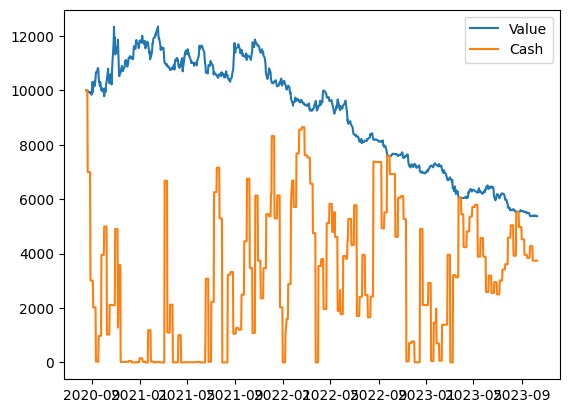

In [41]:
# print graphic history of portfolio with matplotlib
plt.plot(remaining_portfolio.history['date'], remaining_portfolio.history['value'], label='Value')
plt.plot(remaining_portfolio.history['date'], remaining_portfolio.history['cash'], label='Cash')
# plt.plot(remaining_portfolio.history['date'], remaining_portfolio.history['value'] - remaining_portfolio.history['cash'], label='Invested')
plt.legend()
plt.show()


